## Imports

In [ ]:
import copy
import glob
import importlib
import math
import os
import shutil
import sys
from math import pi, radians, degrees
from os.path import *

import keras
import numpy as np
import pylab
import SimpleITK as sitk
from skimage.morphology import ball

import cnn_builder as cbuild
import config
import lipiodol_methods as lm
import niftiutils.helper_fxns as hf
import niftiutils.liver_metrics as lmet
import niftiutils.masks as masks
import niftiutils.registration as reg
import niftiutils.transforms as tr
from config import Config

%matplotlib inline

In [2]:
importlib.reload(hf)
C = config.Config()

In [3]:
img_dir = "D:\\Lipiodol\\Images all"
seg_dir = "D:\\Lipiodol\\Images extracted and segmentations"
target_dir = "D:\\Lipiodol\\Data"

### Corrupt data

In [7]:
big_path = r"C:\Users\Clinton\Desktop\MRI Abdomen W WO Contrast"
header = hf.dcm_load_header(big_path)

In [8]:
dcm_path = [r"C:\Users\Clinton\Desktop\New folder",
        r"C:\Users\Clinton\Desktop\New folder2",
        r"C:\Users\Clinton\Desktop\New folder3",
        r"C:\Users\Clinton\Desktop\New folder4"]

In [9]:
for i in range(4):
    os.makedirs(dcm_path[i])

In [10]:
acq_t = [124326.42, 124404.46, 124446.79, 124633.32]

In [11]:
for ix,fn in enumerate(glob.glob(join(big_path, "*"))):
    h = hf.dcm_load_header(fn)
    for i in range(4):
        if abs(float(h[0].AcquisitionTime) - acq_t[i]) < .02:
            shutil.copy(fn, join(dcm_path[i], basename(fn)))

for fn in glob.glob(join(dcm_path, "*")):
    if int(header[int(fn[-7:-4])-1].TemporalPositionIdentifier) == 2:
        shutil.move(fn, join(dcm_path2, basename(fn)))
    elif int(header[int(fn[-7:-4])-1].TemporalPositionIdentifier) == 3:
        shutil.move(fn, join(dcm_path3, basename(fn)))
    elif int(header[int(fn[-7:-4])-1].TemporalPositionIdentifier) == 4:
        shutil.move(fn, join(dcm_path4, basename(fn)))

In [ ]:
dim = 1
base = float(header[0].SliceLocation)
for x,h in enumerate(header[1:]):
    dz = float(h.SliceLocation) - base
    print(dz)
    base = float(h.SliceLocation)

In [412]:
fn = ["t1-pre.nii", "t1-art.nii", "t1-pv.nii", "t1-equ.nii"]

In [418]:
for i in range(2,3):
    a,dims = hf.dcm_load(dcm_path[i], True, True)
    save_path = join(dirname(dcm_path[i]), "07", fn[i])
    hf.save_nii(a, save_path, dims)

### MRI loading

In [5]:
patient_id = "01"
modality = "MRI-BL"

In [12]:
dcm_paths = [x for x in glob.glob(join(target_dir, patient_id, modality,"*")) if x.find('.')==-1]
for dcm_path in dcm_paths:
    if not exists(splitext(dcm_path)[0] + ".nii"):
        try:
            save_path = splitext(dcm_path)[0] + ".nii"
            img, dims = hf.dcm_load(dcm_path, True, True)
            hf.save_nii(img, save_path, dims)
        except:
            print(dcm_path)

2018-04-05 11:37:49,011 WARNING Slice increment not consistent through all slices
2018-04-05 11:37:49,011 WARNING ---------------------------------------------------------
2018-04-05 11:37:49,011 WARNING [-167.996496   -204.99921608    6.70226672] [ 3.7479401e-04  0.0000000e+00 -1.5000000e+00]
2018-04-05 11:37:49,017 WARNING [-167.99724559 -204.99921608    9.70226672] [ 7.4958801e-04  0.0000000e+00 -3.0000000e+00]
2018-04-05 11:37:49,018 WARNING ---------------------------------------------------------
D:\Lipiodol\Data\01\MRI-BL\T1-70s


In [12]:
paths = [x for x in glob.glob(join(target_dir, patient_id, modality,"*.nii.gz")) if '20s' in x or 'Ph1-Ax' in x]
if len(paths)==1:
    os.rename(paths[0], join(dirname(paths[0]), "mri30d_art.nii.gz"))

In [13]:
paths = [x for x in glob.glob(join(target_dir, patient_id, modality,"*.nii.gz")) \
         if ('pre' in x.lower() and 'post' not in x.lower()) or basename(x).startswith('Ax LAVA-XV')]
if len(paths)==1:
    os.rename(paths[0], join(dirname(paths[0]), "mri30d_pre.nii.gz"))

## Make liver mask

In [15]:
patient_id = "07"
mask_dir = join(target_dir, patient_id, "masks")
nii_dir = join(target_dir, patient_id, "nii_files")
if not exists(nii_dir):
    os.makedirs(nii_dir)

ct24_path = join(target_dir, patient_id, "nii_files", "ct24.nii.gz")
ct24_tumor_mask_path = glob.glob(join(mask_dir, "tumor*24h*.ids"))[0]

mribl_art_path = join(target_dir, patient_id, "MRI-BL", "mribl_art.nii.gz")
mribl_pre_path = join(target_dir, patient_id, "MRI-BL", "mribl_pre.nii.gz")
mribl_tumor_mask_path = join(mask_dir, "tumor_BL_MRI")
mribl_liver_mask_path = join(mask_dir, "mribl_liver")
mribl_enh_mask_path = join(mask_dir, "enh_bl")
mribl_nec_mask_path = join(mask_dir, "nec_bl")
ct24_bl_enh_mask_path = join(mask_dir, "ct24_bl_enh")
ct24_bl_nec_mask_path = join(mask_dir, "ct24_bl_nec")

mri30d_art_path = join(target_dir, patient_id, "MRI-30d", "mri30d_art.nii.gz")
mri30d_pre_path = join(target_dir, patient_id, "MRI-30d", "mri30d_pre.nii.gz")
mri30d_tumor_mask_path = join(mask_dir, "tumor_30dFU_MRI")
mri30d_liver_mask_path = join(mask_dir, "mri30d_liver")
mri30d_enh_mask_path = join(mask_dir, "enh_30d")
mri30d_nec_mask_path = join(mask_dir, "nec_30d")
ct24_30d_enh_mask_path = join(mask_dir, "ct24_30d_enh")
ct24_30d_nec_mask_path = join(mask_dir, "ct24_30d_nec")

In [13]:
model = keras.models.load_model(join(Config().model_dir, "mri_liver.hdf5"))

In [16]:
lm.seg_liver_mri_from_path(mri30d_art_path, mri30d_liver_mask_path, model, mri30d_tumor_mask_path)

## Non-rigid reg

In [464]:
importlib.reload(reg)

<module 'niftiutils.registration' from 'c:\\users\\clinton\\documents\\niftiutils\\niftiutils\\registration.py'>

In [18]:
ct_img, ct_dims = hf.dcm_load(join(target_dir, patient_id, "CT24h"), True, True)
hf.save_nii(ct_img, ct24_path, ct_dims)

In [37]:
threshold = 24.142
lmet.seg_tumor_from_threshold(mribl_art_path, mribl_pre_path,
                              threshold, mribl_tumor_mask_path,
                              mribl_enh_mask_path, mribl_nec_mask_path)
threshold = 42.185
lmet.seg_tumor_from_threshold(mri30d_art_path, mri30d_pre_path,
                              threshold, mri30d_tumor_mask_path,
                              mri30d_enh_mask_path, mri30d_nec_mask_path)

#qEASLy to produce enhancing mask
#importlib.reload(lmet)
_=lmet.segment_tumor_from_paths(mribl_art_path, mribl_pre_path,
                              mribl_liver_mask_path, mribl_tumor_mask_path,
                              mribl_enh_mask_path, mribl_nec_mask_path)
_=lmet.segment_tumor_from_paths(mri30d_art_path, mri30d_pre_path,
                              mri30d_liver_mask_path, mri30d_tumor_mask_path,
                              mri30d_enh_mask_path, mri30d_nec_mask_path)

In [17]:
xform_path, crops, pads = reg.get_mask_Tx(ct24_path, ct24_tumor_mask_path, mribl_art_path, mribl_tumor_mask_path)

# Transform using existing transform
_ = reg.transform_mask(mribl_enh_mask_path, mribl_art_path, xform_path,
                     crops, pads, ct_dims, ct24_bl_enh_mask_path)
_ = reg.transform_mask(mribl_nec_mask_path, mribl_art_path, xform_path,
                     crops, pads, ct_dims, ct24_bl_nec_mask_path)

In [143]:
xform_path, crops, pads = reg.get_mask_Tx(ct24_path, ct24_tumor_mask_path, mri30d_art_path, mri30d_tumor_mask_path)

# Transform using existing transform
_ = reg.transform_mask(mri30d_enh_mask_path, mri30d_art_path, xform_path,
                     crops, pads, ct_dims, ct24_30d_enh_mask_path)
_ = reg.transform_mask(mri30d_nec_mask_path, mri30d_art_path, xform_path,
                     crops, pads, ct_dims, ct24_30d_nec_mask_path)

In [30]:
ball_ct24_path = join(target_dir, patient_id, "nii_files", "ct24_ball.nii")
ball_mribl_path = join(target_dir, patient_id, "nii_files", "mribl_ball.nii")
ball_mri30d_path = join(target_dir, patient_id, "nii_files", "mri30d_ball.nii")
ball_mask_path = join(mask_dir, "ball_mask")
ball_mribl_enh_mask_path = join(mask_dir, "ball_mribl_enh_mask")
ball_mri30d_enh_mask_path = join(mask_dir, "ball_mri30d_enh_mask")

lipiodol_mask_path = join(mask_dir, "high_lipiodol")
ball_lipiodol_mask_path = join(mask_dir, "ball_lipiodol")

In [40]:
importlib.reload(reg)

xform_path, crops, pads = reg.get_mask_Tx_shape(ct24_path, ct24_tumor_mask_path, mask_path=ball_mask_path)
img = reg.transform_region(ct24_path, xform_path, crops, pads, [1.]*3, ball_ct24_path)
masks.restrict_mask_to_largest(lipiodol_mask_path, ball_lipiodol_mask_path)
_ = reg.transform_mask(ball_lipiodol_mask_path, ct24_path, xform_path,
                     crops, pads, [1.]*3, ball_lipiodol_mask_path)

xform_path, crops, pads = reg.get_mask_Tx_shape(mribl_art_path, mribl_tumor_mask_path)
_ = reg.transform_region(mribl_art_path, xform_path, crops, pads, [1.]*3, ball_mribl_path)
_ = reg.transform_mask(mribl_enh_mask_path, mribl_art_path, xform_path,
                     crops, pads, [1.]*3, ball_mribl_enh_mask_path)

xform_path, crops, pads = reg.get_mask_Tx_shape(mri30d_art_path, mri30d_tumor_mask_path)
_ = reg.transform_region(mri30d_art_path, xform_path, crops, pads, [1.]*3, ball_mri30d_path)
_ = reg.transform_mask(mri30d_enh_mask_path, mri30d_art_path, xform_path,
                     crops, pads, [1.]*3, ball_mri30d_enh_mask_path)

## debugging

In [270]:
fix_tmp_path="D:\\temp_fix.nii"
mov_tmp_path="D:\\temp_mov.nii"

img_m, img_m_dims = hf.nii_load(img_mov_path)
mask_m, mask_m_dims = masks.get_mask(mask_mov_path, img_m_dims, img_m.shape)

mask_m, crops_m = hf.crop_nonzero(mask_m)
img_m, _ = hf.crop_nonzero(img_m, crops_m)
img_m[mask_m == 0] = 0

R = 1.
mask_m_iso, _ = tr.rescale_img(mask_m, [R]*3, mask_m_dims)

mask_f = ball(max(mask_m_iso.shape)//2)
mask_f_iso = np.pad(mask_f, (np.ones((3,2))*5).astype(int), 'constant')
mask_m_iso, pads_m = hf.zeropad(mask_m_iso, mask_f_iso.shape, ignore_neg=True)

In [271]:
mask_m_iso.max()

255.0

In [233]:
mask_m_iso=((mask_m_iso>mask_m_iso.max()/2)*255).astype('uint8')

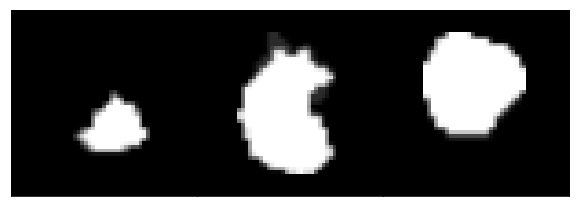

In [272]:
hf.draw_slices(mask_m_iso)

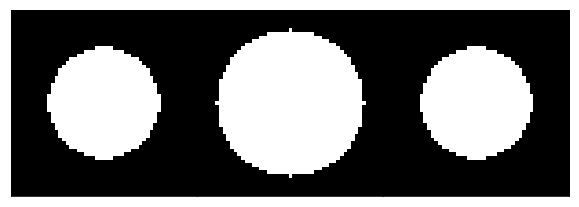

In [235]:
hf.draw_slices(mask_f_iso)

In [258]:
hf.save_nii(mask_f_iso*255, fix_tmp_path, [R]*3)
hf.save_nii(mask_m_iso, mov_tmp_path, [R]*3)

In [237]:
out_img_path="D:\\temp.nii"

In [273]:
importlib.reload(reg)
reg.reg_aligned_masks(mov_tmp_path, fix_tmp_path, out_img_path=out_img_path)

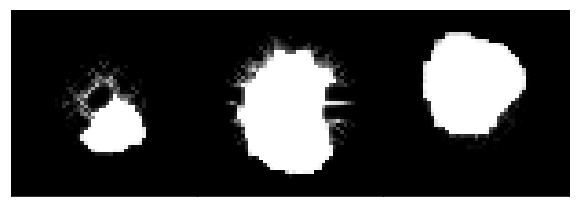

In [274]:
out_img,dims = hf.nii_load(out_img_path)
hf.draw_slices(out_img)

### Compose with rotation

In [191]:
mribl_liver_mask_path = join(target_dir, patient_id, "liver bl final.ids")
ct24_liver_mask_path = glob.glob(join(target_dir, patient_id, "wholeliver_24hCT*.ids"))[0]

In [ ]:
mribl_ct24_xform, ct24_tumor, mribl_tumor, mribl_ct24_crops = full_reg_masks(ct24_tumor_mask_path, ct24_path, mribl_tumor_mask_path, mribl_art_path)

In [ ]:
# BL MRI to 24h CT
vec_field = lm.reg_masks(ct_tumor_mask_path, blmri_tumor_mask_path)

In [ ]:
mribl_enh_mask = reg.apply_field(vec_field)

In [ ]:
ct24_lip = lm.seg_lipiodol()

In [ ]:
reg.reg_sitk(ct24_lip, vec_field)

In [114]:
mri_dcm_paths = [x for x in glob.glob(join(target_dir, '*', 'MRI-BL', '*20s*')) if '.nii' not in x]
mri_dcm_paths

In [ ]:
path_dict = {}
patient_id = '04'
for path in glob.glob(join(target_dir, patient_id, "MRI-BL","*","*")):
    header = hf.dcm_load_header(path)
    if len(header) > 0:
        series_descript = header[0][('0008', '103e')].value
        path_dict[path] = series_descript
        series_descript = series_descript.replace("/","-")
        os.rename(path, join(target_dir,patient_id, "MRI-BL", series_descript))

In [499]:
for path in glob.glob(join(target_dir, "*", "masks","*final*")):
    if not exists(path.replace(" final", "")):
        os.rename(path, path.replace(" final", ""))

for path in glob.glob(join(target_dir, "*")):
    os.makedirs(join(path, "masks"))

for path in glob.glob(join(target_dir, "*", "*.off")):
    os.rename(path, join(dirname(path), "masks", basename(path)))

### Bias field corr

In [122]:
mri_raw_paths = glob.glob(join(target_dir, '*', 'MRI-BL', 't1-art.nii.gz'))
mri_bfc_paths = [join(dirname(x), "t1-art-bfc.nii.gz") for x in mri_raw_paths]

In [176]:
importlib.reload(masks)

<module 'niftiutils.masks' from 'c:\\users\\clinton\\documents\\niftiutils\\niftiutils\\masks.py'>

In [ ]:
glob.glob(join(target_dir, patient_id, ''

In [ ]:
masks.mask2nii()

In [128]:
inputImage = sitk.ReadImage(mri_raw_paths[0])
maskImage = sitk.OtsuThreshold( inputImage, 0, 1, 200 )

if len ( sys.argv ) > 3:
    inputImage = sitk.Shrink( inputImage, [ int(sys.argv[3]) ] * inputImage.GetDimension() )
    maskImage = sitk.Shrink( maskImage, [ int(sys.argv[3]) ] * inputImage.GetDimension() )

inputImage = sitk.Cast( inputImage, sitk.sitkFloat32 )

corrector = sitk.N4BiasFieldCorrectionImageFilter()

numberFilltingLevels = 4
#corrector.SetMaximumNumberOfIterations( [ int( sys.argv[5] ) ] *numberFilltingLevels  )

output = corrector.Execute( inputImage, maskImage )

sitk.WriteImage( output, mri_bfc_paths[0] )

# Pattern analysis

### Masks

In [ ]:
IVs = np.zeros((181,361,5)) # avg voxel intensity

In [ ]:
highest_I_V = -1000

#fix dphi at 360
for theta in range(0, 181):
    for phi in range(-180, 181):
        for dz in range(1,5):
            params = radians(theta1), radians(phi1), radians(dtheta), dz/10
            I_V = get_intensity_section(ball_ct24_path, ball_mask_path, params)
            if highest_I_V < I_V:
                best_params = params
                highest_I_V = I_V
                print(best_params)
                        
theta1_best, phi1_best, dtheta_best, dz_best = best_params

In [98]:
X = np.linspace(0,1,50)

In [99]:
Y = [math.acos(x) for x in X]

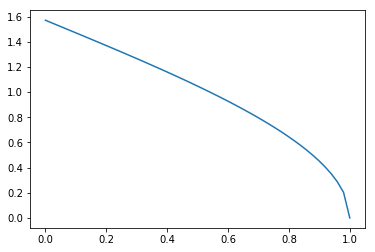

In [103]:
pylab.plot(X,Y)

In [60]:
def get_avg_ball_intensity(reg_img_path, ball_mask_path):
    img, dims = hf.nii_load(reg_img_path)
    ball, _ = masks.get_mask(ball_mask_path)
    nonzeros = np.argwhere(ball)
    
    R = (nonzeros[:,0].max() - nonzeros[:,0].min()) / 2
    m = ball.shape[0]//2
    img[ball == 0] = np.nan
    V = ball.sum()
    I = np.nansum(img)
    return I/V

In [68]:
def get_intensity_section(reg_img_path, ball_mask_path, params):
    theta1, phi1, dtheta, dphi, dz = params
    theta2 = theta1 + dtheta
    phi2 = phi1 + dphi
    
    img, dims = hf.nii_load(reg_img_path)
    ball, _ = masks.get_mask(ball_mask_path)
    nonzeros = np.argwhere(ball)
    
    R = (nonzeros[:,0].max() - nonzeros[:,0].min()) / 2
    r = R * (1-dz)
    m = ball.shape[0]//2
    
    for x in range(ball.shape[0]):
        for y in range(ball.shape[1]):
            for z in range(ball.shape[2]):
                if ball[x,y,z] == 0:
                    continue
                    
                X = m-.5-x
                Y = m-.5-y
                Z = m-.5-z
                RR = (X*X+Y*Y+Z*Z)**.5
                theta = math.acos(Z/RR)
                if theta + theta1:
                    theta += 2*pi
                phi = math.atan2(Y,X)
                if RR <= R and RR >= r and theta >= theta1 and theta <= theta2 and phi >= phi1 and phi <= phi2:
                    ball[x,y,z] = 1

    img[ball == 0] = np.nan
    V = ball.sum()
    I = np.nansum(img)
    return I/V

In [74]:
D = np.zeros(ball.shape)
for x in range(D.shape[0]):
    for y in range(D.shape[1]):
        for z in range(D.shape[2]):
            X = m-.5-x
            Y = m-.5-y
            Z = m-.5-z
            RR = (X*X+Y*Y+Z*Z)**.5
            theta = math.acos(Z/RR)
            phi = math.atan2(Y,X)

In [93]:
X=1
Y=-1
Z=1
RR = (X*X+Y*Y+Z*Z)**.5
math.acos(Z/RR), math.atan2(Y,X)

(0.9553166181245092, -0.7853981633974483)

## Lipiodol seg

In [26]:
importlib.reload(lm)

# Lipiodol 3 masks
info = {}
for seg in glob.glob(join(mask_dir, "wholeliver_24hCT*.ids")):
    if dirname(seg) in info.keys():
        (ct_img, ct_dims, mask) = info[dirname(seg)]
    else:
        ct_img, ct_dims = hf.dcm_load(join(target_dir, patient_id, "CT24h"), True, True)
        mask, _ = masks.get_mask(seg, ct_dims, ct_img.shape)
        
    lm.seg_lipiodol((mask > 0) * ct_img, dirname(seg), ct_dims)
    info[dirname(seg)] = (ct_img, ct_dims, mask)
    break

In [ ]:
# Lipiodol target vs non-target masks
info = {}
for seg in glob.glob(join(target_dir,"*","wholeliver_24hCT*.ids")):
    if dirname(seg) in info.keys():
        (ct_img, ct_dims, mask) = info[dirname(seg)]
    else:
        ct_img, ct_dims = hf.dcm_load(join(dirname(seg), "CT24h"), True, True)
        mask, _ = masks.get_mask(seg, ct_dims, ct_img.shape)
        
    lm.seg_target_lipiodol((mask > 0) * ct_img, dirname(seg), ct_dims)
    info[dirname(seg)] = (ct_img, ct_dims, mask)
    #break